In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import re
import pynlpir
pynlpir.open()

from generate import *
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

### Load model

In [2]:
model = torch.load('all.txt.model').cuda()

### Helper functions

In [3]:
def wrap_colored_output(text, colors, W=20):
    ''' Wrap text with hidden units to certain width '''
    new_text, new_colors = [], []
    for char, color in zip(text, colors):
        new_text.append(char)
        new_colors.append(color)
        if char == '\n':
            for i in range(W - len(new_text) % W):
                new_text.append(' ')
                new_colors.append(np.zeros_like(colors[0]))
    for i in range(W - len(new_text) % W):
        new_text.append(' ')
        new_colors.append(np.zeros_like(colors[0]))
    
    return np.array(new_text).reshape(-1, W), np.array(new_colors).reshape(-1, W)

In [97]:
def plot_colored_text(text, colors, W=60, title=None, save_file=None):
    wrapped_text, wrapped_colors = wrap_colored_output(text, colors, W=W)
    
    H = len(wrapped_text)
    plt.figure(figsize=(W/5, H/3))
    sns.heatmap(wrapped_colors, annot=wrapped_text, fmt='s',
                cbar=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    if save_file:
        plt.savefig(save_file)
    plt.show()

In [98]:
text, hiddens = generate(model, '\n\n', 500, 0.8, True)
hiddens = hiddens.reshape(text_len, -1)
print(text)

own:
He will grace is in make say your two trice thee:
My wife, I not puny and Angelo, he live;
To the cold their take the fair all he hath man
For be the about that company to thee on the
the truce appear alas have in when the swortunes;
For I thy takes a doth must in leave,
Her, and live. My laugh your new in was a call'd
Who still made the trumpet; his commonds,
Which it consepery this vie.

QUEEN MARGARET:
My callies, the mother's shame my sister.

ANTONIO:
The foe is storge have in the sham


### Define hypotheses

In [99]:
def hypothesis_inlinecounter(text):
    hyp = np.concatenate([np.linspace(1, -1, len(x)+1) for x in text.split('\n')])[:-1]
    return hyp

def hypothesis_capswords(text):
    hyp = np.concatenate([np.full(len(x)+1, 1) if re.sub('[^a-zA-Z]+', '', x).isupper() else np.full(len(x)+1, -1) for x in text.split('\n')])[:-1]
    return hyp

def hypothesis_pos(text, pos_tag):
    hyp = text.replace('1', '0')
    for word, tag in pynlpir.segment(text):
        if tag == pos_tag:
            hyp = hyp.replace(word, '1'*len(word), 1)
        else:
            hyp = hyp.replace(word, '0'*len(word), 1)
    hyp = [1 if x=='1' else -1 for x in re.sub('[^1]', '0', hyp)]
    
    return hyp

def hypothesis_verbs(text):
    return hypothesis_pos(text, 'verb')

def hypothesis_nouns(text):
    return hypothesis_pos(text, 'noun')

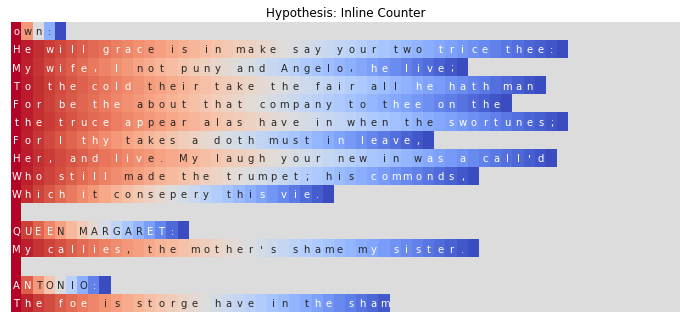

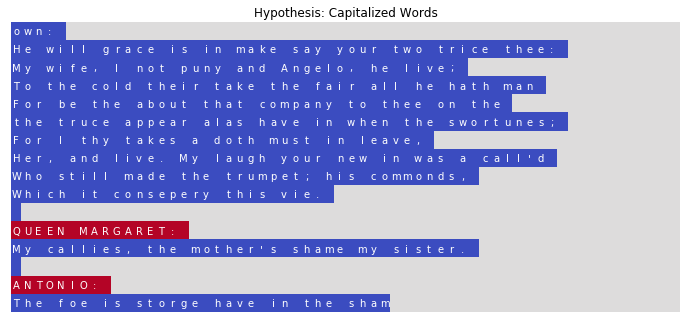

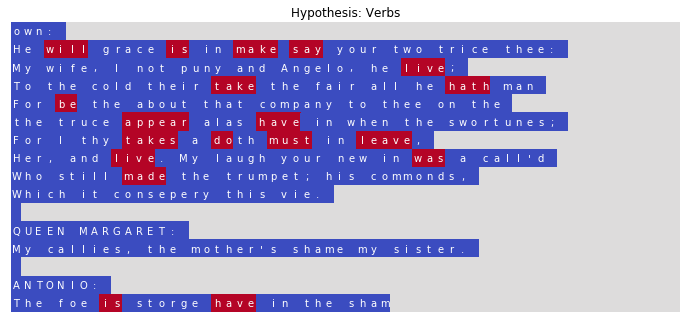

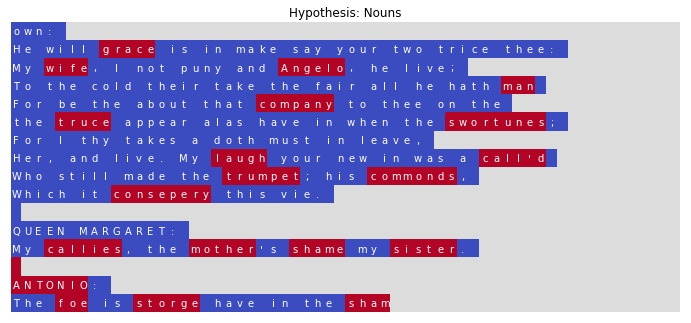

In [101]:
plot_colored_text(text, hypothesis_inlinecounter(text), title='Hypothesis: Inline Counter', save_file='hyp_inlinecounter.png')
plot_colored_text(text, hypothesis_capswords(text), title='Hypothesis: Capitalized Words', save_file='hyp_capswords.png')
plot_colored_text(text, hypothesis_verbs(text), title='Hypothesis: Verbs', save_file='hyp_verbs')
plot_colored_text(text, hypothesis_nouns(text), title='Hypothesis: Nouns', save_file='hyp_nouns')

### Hypothesis Validation using Diagnostic Classifier

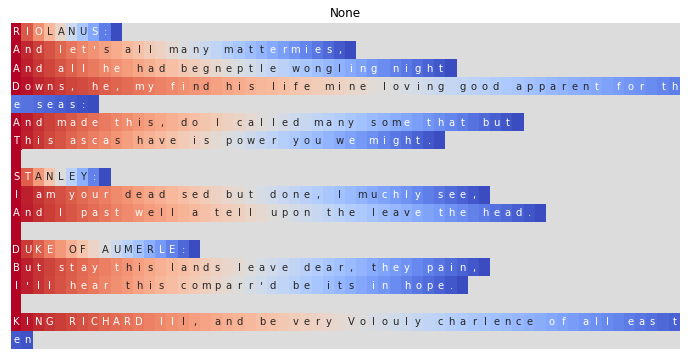

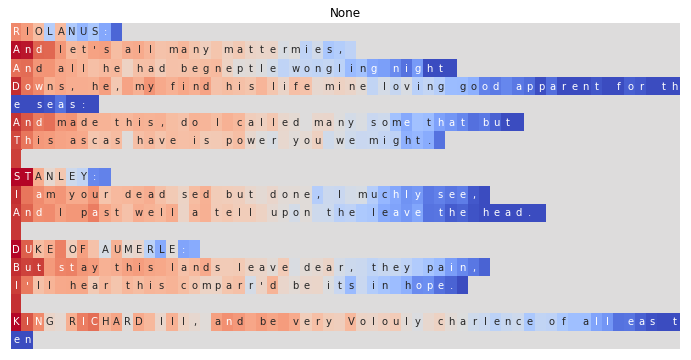

0.514


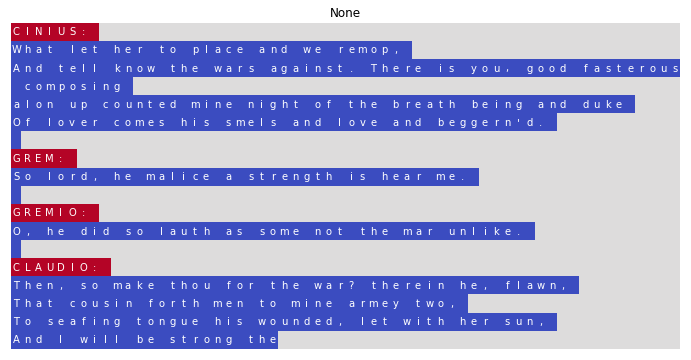

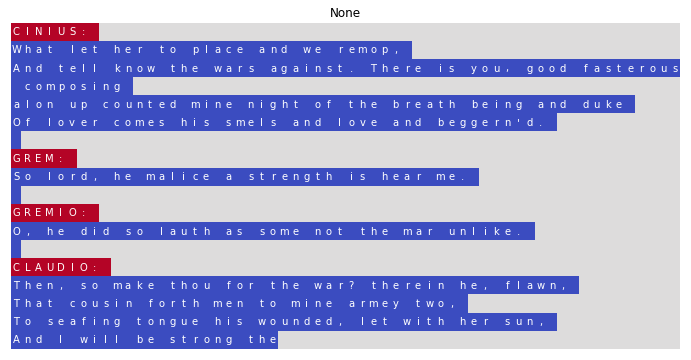

0.999


part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'


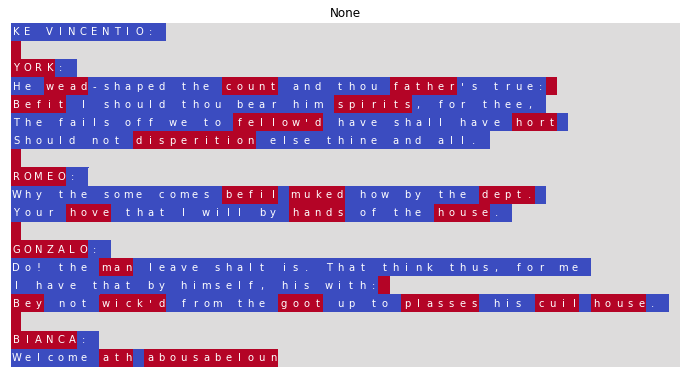

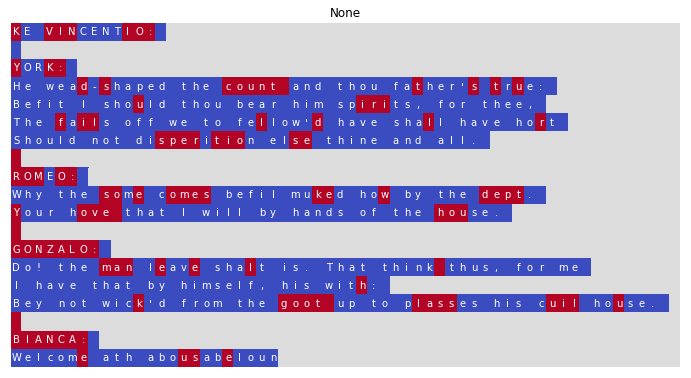

0.743


part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'
part of speech not recognized: 'gjtgj'


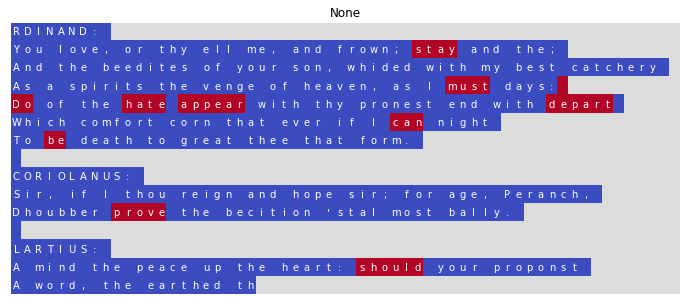

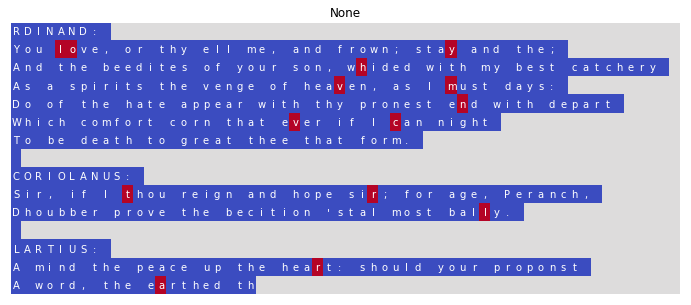

0.901


In [103]:
def validate_hypothesis(model, diag_classifier, hypothesis, train_len=50, test_len=2, text_len=500, plot=True, signcheck=False):
    # Generate hypothesis data
    def gen_hyp_data(model, N, text_len=500):
        texts, hiddens, hyps = [], [], []
        for i in range(N):
            text, hidden = gen_text(model, text_len)
            hidden = hidden.reshape(-1, hidden.shape[-1])
            hyp = hypothesis(text)
            hiddens.append(hidden)
            hyps.append(hyp)
            texts.append(text)
        return ''.join(texts), np.concatenate(hyps), np.concatenate(hiddens)

    # Generate train and test data
    _, train_hyps, train_hiddens = gen_hyp_data(model, train_len)
    test_texts, test_hyps, test_hiddens = gen_hyp_data(model, test_len)

    # Train diagnostic classifir
    diag_classifier.fit(train_hiddens, train_hyps)
    pred_hyps = diag_classifier.predict(test_hiddens)
    
    # Plot result
    if plot:
        plot_colored_text(test_texts[text_len:], test_hyps[text_len:], title='Formed Hypothesis')
        plot_colored_text(test_texts[text_len:], pred_hyps[text_len:], title='Diagnostic Classifier Prediction')
    
    # Correct
    if signcheck:
        correct = np.sign(pred_hyps) == np.sign(test_hyps)
    else:
        thres = 0.2
        correct = np.abs(pred_hyps - test_hyps) < thres
    
    # Return precision
    # print(list(zip(pred_hyps, test_hyps, correct)))
    return sum(correct) / len(correct)

print(validate_hypothesis(model, LinearRegression(), hypothesis_inlinecounter))
print(validate_hypothesis(model, LogisticRegression(), hypothesis_capswords, signcheck=True))
print(validate_hypothesis(model, LogisticRegression(), hypothesis_nouns))
print(validate_hypothesis(model, LogisticRegression(), hypothesis_verbs))

In [14]:
wrapped_text

NameError: name 'wrapped_text' is not defined